# Classifying Reddit Autos Selfposts<div class="tocSkip">
    
&copy; Jens Albrecht, 2023
    
This notebook can be freely copied and modified.  
Attribution, however, is highly appreciated.

<hr/>

See also: 

Albrecht, Ramachandran, Winkler: **Blueprints for Text Analytics in Python** (O'Reilly 2020)  
Chapter 6: [Text Classification Algorithms](https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch06.html#ch-classification) + [Link to Github](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/README.md)

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2021-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append(f'{BASE_DIR}/packages')

## Preparing Data for Machine Learning

### Load Data

In [3]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-prepared.csv", sep=";", decimal=".")

len(df)

24712

In [39]:
# set display column width unlimited to show full text
pd.set_option('max_colwidth', None)

df[['subreddit', 'title', 'text', 'lemmas', 'nouns', 'brands', 'models']].sample(2)

# reset display column width to 30
pd.reset_option('max_colwidth')

,subreddit,title,text,lemmas,nouns,brands,models
16571,Audi,Audi throwback 2013 A4 spy shots,"Audi throwback 2013 A4 spy shots: Spy shots or 2013 A4 B8.5 facelift back in summer 2011 before reveal The 2012 Audi A4 is currently on sale in the U.S., so the freshened car is expected to make its debut late this year or early next before going on sale as a 2013 model. An all-new, lighter-weight B9 Audi A4 is due around 2015, so this new look will hold the A4 over until then. _URL_",audi throwback 2013 a4 spy shot spy shot 2013 a4 b8.5 facelift summer 2011 reveal 2012 audi a4 sale u.s. freshened car expect make debut late this year go sale 2013 model new light weight b9 audi a4 due new look hold a4 url _,audi throwback a4 spy shot spy shot a4 b8.5 summer 2011 audi a4 sale u.s. car debut late this year sale model weight b9 audi a4 look a4 url _,audi,a4 a4 a4
18064,motorcycles,Riding help,"Riding help: Been riding for 10 years, I guess age caught me. I have a k6 750 love her since day one. Problem is my knees hurt when I ride, hell going to the store my knees hurt. Any suggestions?",riding help ride 10 year guess age catch have k6 750 love day one problem knee hurt ride hell go store knee hurt suggestion,riding help 10 year age k6 love day one problem knee hell store knee suggestion,NaN,NaN


### Define Label

Store the label in a variable to make modifications easier.

In [5]:
label = 'subreddit'

In [6]:
df[label].value_counts().to_frame()

,count
subreddit,
motorcycles,5654
AskMechanics,2713
teslamotors,2515
BMW,2303
Audi,2053
Honda,1957
Volkswagen,1657
Hyundai,1433
Toyota,1145


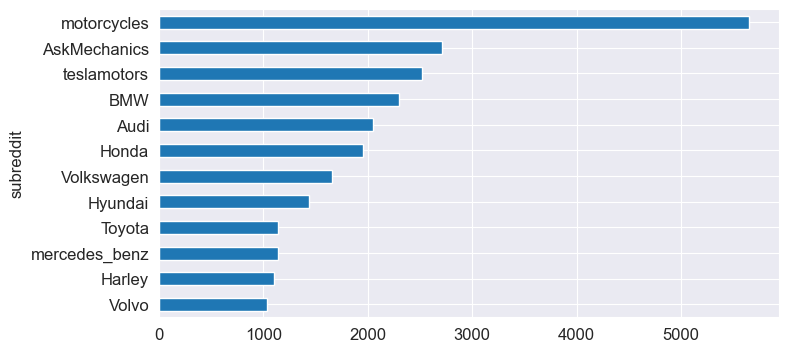

In [7]:
df[label].value_counts().plot(kind='barh').invert_yaxis()

### Vectorization

Here we use scikit-learn's TF-IDF vectorizers for bag-of-words vectorization, i.e. creating the TF or TF-IDF matrix.

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn-feature-extraction-text-countvectorizer

In [8]:
# choose text column for vectorization
text_col = 'lemmas'

#### Term-Frequency Matrix (Counts)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# learn vocabulary for all data
count_vect = CountVectorizer(ngram_range=(1, 1), 
                             min_df=1, 
                             max_df=1.0, 
                             lowercase=True,
                             stop_words=None,
                             tokenizer=str.split)

# alternatively: only nouns or nouns+adjs+verbs
X_tf = count_vect.fit_transform(df[text_col])

type(X_tf)
X_tf.shape

scipy.sparse._csr.csr_matrix

(24712, 39562)

Optional: Play with hyperparameters i.e.

  * `ngram_range=(1, 2)` to include bigrams
  * `max_df=0.5` to exclude words occuring in more than 50% of the documents
  * `min_df=2` to include only words occuring in at least 2 documents

#### TF-IDF-Matrix

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vect = TfidfTransformer()

X_tfidf = tfidf_vect.fit_transform(X_tf)

X_tfidf.shape

(24712, 39562)

### Train-Test-Split

Choose data matrix `X` and label vector `y` for training:

In [11]:
# alternatively: X = X_tf
X = X_tfidf

# define label vector
y = df[label]

Now split with `train_test_split()`.

Recommendation: use `stratify=y`

In [12]:
from sklearn.model_selection import train_test_split

# define holdout
test_size = 0.2

if test_size > 0.0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size,
                                                        stratify = y,
                                                        random_state=43
                                                       )
else:
    X_train, X_test, y_train, y_test = X, None, y, None
    
    
print("Trainigsmatrix:", X_train.shape)
print("Testmatrix:    ", X_test.shape)

Trainigsmatrix: (19769, 39562)
Testmatrix:     (4943, 39562)


Store information about train/test records in data frame.

In [13]:
df['train_test'] = pd.Series(df.index.isin(y_test.index)).map(lambda x: 'Test' if x else 'Train')

In [14]:
df['train_test'].value_counts().to_frame()

,count
train_test,
Train,19769
Test,4943


Stratification enforces 80:20 split even within classes:

In [15]:
df[[label, 'train_test']].pivot_table(index=label, columns='train_test', aggfunc=len, fill_value=0)

train_test,Test,Train
subreddit,,
AskMechanics,543,2170
Audi,411,1642
BMW,461,1842
Harley,220,881
Honda,391,1566
Hyundai,287,1146
Toyota,229,916
Volkswagen,331,1326
Volvo,207,829


## Training and Evaluation


### Support Vector Machine

We use the Support Vector Machine for training which works excellent for TF-IDF vectors. Fastest implementation is `LinearSVC`, but allows only linear kernels. Alternatively use `SGDClassifier`.
To use a different classifier like logistic regression, just uncomment the respective lines.

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

In [16]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression

print(f'Training on column {label}')

clf = LinearSVC(C=1.0)
# clf = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)

clf.fit(X_train, y_train);

print("Done.")

Training on column subreddit


LinearSVC()

Done.


Extremely fast, right!?

### Evaluation

Apply classifier to test data with `predict()`.

In [17]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f"Classifier: {clf.__class__}\n")

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Classifier: <class 'sklearn.svm._classes.LinearSVC'>

Accuracy Summary
Test:     86.41%
Train:    98.64%


Not bad for a 12-class classifier!

$$Accuracy = \frac{\text{number of correctly classified data points}}{\text{all data points}}$$

In [18]:
sum(y_test == y_test_pred)/len(y_test)

0.864050171960348

Looking at the per-class metrics with `classification_report`:

In [19]:
from sklearn.metrics import classification_report

print("Classification Report")
print("=====================")
print(classification_report(y_true=y_test, y_pred=y_test_pred))

Classification Report
               precision    recall  f1-score   support

 AskMechanics       0.67      0.70      0.69       543
         Audi       0.93      0.89      0.91       411
          BMW       0.88      0.87      0.88       461
       Harley       0.80      0.60      0.69       220
        Honda       0.87      0.85      0.86       391
      Hyundai       0.93      0.91      0.92       287
       Toyota       0.81      0.86      0.84       229
   Volkswagen       0.88      0.85      0.86       331
        Volvo       0.94      0.89      0.92       207
mercedes_benz       0.93      0.81      0.87       229
  motorcycles       0.87      0.95      0.91      1131
  teslamotors       0.94      0.94      0.94       503

     accuracy                           0.86      4943
    macro avg       0.87      0.84      0.86      4943
 weighted avg       0.87      0.86      0.86      4943



And on the training data:

In [20]:
print("Classification Report")
print("=====================")
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Classification Report
               precision    recall  f1-score   support

 AskMechanics       0.98      0.94      0.96      2170
         Audi       0.99      0.99      0.99      1642
          BMW       0.99      0.99      0.99      1842
       Harley       0.98      0.95      0.96       881
        Honda       0.98      0.99      0.98      1566
      Hyundai       0.99      0.99      0.99      1146
       Toyota       0.98      0.99      0.98       916
   Volkswagen       0.99      0.99      0.99      1326
        Volvo       0.99      1.00      1.00       829
mercedes_benz       1.00      0.99      0.99       916
  motorcycles       0.99      0.99      0.99      4523
  teslamotors       1.00      1.00      1.00      2012

     accuracy                           0.99     19769
    macro avg       0.99      0.99      0.99     19769
 weighted avg       0.99      0.99      0.99     19769



### Confusion Matrix

Visualizing the `confusion_matrix`.

Not surprisingly, the generic category "AskMechanics" is frequently confused.

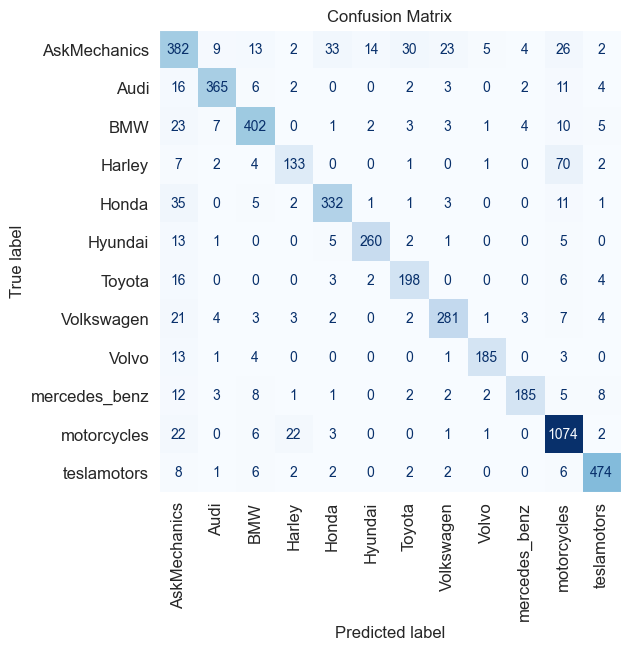

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_preds, labels):
    cm = confusion_matrix(y_true, y_preds, normalize=None) # or None
    fig, ax = plt.subplots(figsize=(6, 6))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".0f", ax=ax, colorbar=False, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()
    
    
# label names - specifies order in confusion matrix
label_names = sorted(y_test.unique())

plot_confusion_matrix(y_test, y_test_pred, label_names)

### Checking misclassified Data

Looking at samples of misclassified and correctly classified data.

Add the predictions to the dataframe to simplify the analysis:

In [22]:
# transform prediction vectors to pandas series with correct indexes
y_test_pred = pd.Series(y_test_pred, index=y_test.index)
y_train_pred = pd.Series(y_train_pred, index=y_train.index)

df['pred'] = pd.concat([y_test_pred, y_train_pred])

Check sample of misclassified data:

In [23]:
# adjust size of visible columns
pd.set_option('max_colwidth', 3000)

df.query(f'train_test=="Test" and {label}!=pred')[[label, 'pred', 'text', text_col]].sample(5)

,subreddit,pred,text,lemmas
10192,Volkswagen,Volvo,Tuareg questions: I'm looking at a Tuareg for my daughter. Tell me what you love. I need safe reliable. It's a 2006 with 118K miles for 6K roughly. One owner Is this too good to be true?,tuareg question look tuareg daughter tell love need reliable 2006 118k mile 6 k one owner good be true
6648,AskMechanics,motorcycles,"Makeshift Throttle / Blip Switch: Please forgive me for this absolute trainwreck of a question but I am trying to commission art of a character's escape from slavery aboard an ocean liner using a home made paramotor circa 1927. I am completely out of my lane here with very novice knowledge surrounding engines as a whole. For an engine I decided to go with a 1917 Indian PowerPlus motorcycle engine mounted to some metal piping with wood heat shielding, mooring rope for a harness, and discarded railing as a chute rope guard to prevent it pulling back into the prop blade (ornamental decoration). See Images here, and yes weight would be a massive issue but I'm not super bothered about that as they have help to carry it to the spot where they jump from. While I'm sure this is absolutely riddled with reasons as to why it would never actutally survive a flight I'm currently trying to determine what the best means of RPM control would be without having to actually engineer too much, any insight or suggestions would be massively appreciated. As of now I'm torn between a blip switch (though unsure how to represent that to the artist as not even sure how the alternator circuit works exactly), or potentially just squeezing the fuel line in a way that restricts fuel flow like a caveman's mixture control. (is that possible?, Is there a better way than just squeezing rubber hose?) Last of all basically any insight into how to improve upon this without changing too much would go a long way. All my thanks in advance!",makeshift throttle blip switch forgive absolute trainwreck question try commission art character escape slavery ocean liner use home make paramotor circa 1927 lane very novice knowledge surround engine whole engine decide go 1917 indian powerplus motorcycle engine mount metal piping wood heat shielding mooring rope harness discard rail chute rope guard prevent pull prop blade ornamental decoration see image weight be massive issue be bother have help carry spot jump be sure riddled reason survive flight try determine good mean rpm control be have engineer insight suggestion appreciate tear blip switch unsure represent artist sure alternator circuit work squeeze fuel line way restrict fuel flow caveman mixture control possible well way squeeze rubber hose last insight improve change much go long way thank advance
8248,Volvo,motorcycles,"Help with wheel adapters: So I have some wheels from a 94 S10 that would work for giving me a wider tire kind of easily without killing the overall look of my 940 (plus the same height), problem is I know next to nothing of wheel adapters. It would need: A 5x108 to 5x120, 25mm offset, and 65.1 to 70.3 center bore. I found a set that has everything but the center bore, and if anyone could point me in the right direction of whether or not I even need to worry about the center bore/it being hub centric, I'd appreciate it very much",help wheel adapter have wheel 94 s10 work give wide tire kind kill overall look 940 same height problem know wheel adapter need 5x108 5x120 25mm offset 65.1 70.3 center bore find set have center bore point right direction need worry center bore be hub centric appreciate
4684,Harley,Toyota,"[Question] Leather seat maintenance: Hey gents with leather seats, How often do you do maintenance on your leather seat? And which leather conditioner do you recommend? I am getting a new seat myself and would love to hear from you guys.",question leather seat maintenance gent leather seat do maintenance leather seat leather conditioner recommend get new seat love hear guy
23984,Harley,motorcycles,Be Safe This Holiday Weeken

Check sample of correctly classified data:

In [24]:
df.query(f'train_test=="Test" and {label}==pred')[[label, 'pred', 'text', text_col]].sample(5)

,subreddit,pred,text,lemmas
4124,mercedes_benz,mercedes_benz,Do you want future Mercedes cars to be keyless?: Do you? View Poll,want future mercedes car be keyless do view poll
917,AskMechanics,AskMechanics,"2014 Nissan Rogue SV Driver Seat Motor Not Working One Direction: Hello Everyone, I have a 2014 Nissan Rogue SV where the driver seat motor will not move the seat backwards; only forwards. I found a few videos for some older models but nothing specific to mine. I am wondering if there is some sort of manual part/bar/something in the car i can use to manually force the seat backwards, and then resume using the driver seat, instead of using the motor button. The seat does move back and forth without an issue pulling the bar under the seat. Is there something similar for automatic recline up and down? Thanks!",2014 nissan rogue sv driver seat motor working one direction have 2014 nissan rogue sv driver seat motor move seat find few video old model specific wonder sort manual part bar car use force seat resume use driver seat use motor button seat move issue pull bar seat similar automatic recline thank
2476,Toyota,Toyota,"Toyota Highlander 2013 v6 AWD: Currently looking to upgrade to a bigger car. I came across a Highlander 2013 with 42,500KM (~26,408miles) for $23,000CAD (~$18,100USD) The car is mint, 1 senior owner that purchased it brand new at the time. Car runs like butter and is overall in fantastic shape. I am just wondering if the price is fair as I know Highlanders tend to keep their value. I am located where it snows so naturally car comes in contact with salt each year. Owner told me he mostly kept it in his garage and it shows because I didnt see any kind of rust. Any known problem with that year Highlander? Are they low maintenance? How good are they on gas? Is this a good purchase overall?","toyota highlander 2013 v6 awd look upgrade big car come highlander 2013 42,500km 23,000cad ~$18,100usd car mint 1 senior owner purchase brand new time car run butter be overall fantastic shape wonder price fair know highlander tend keep value locate snow car come contact salt each year owner tell keep garage show see kind rust know problem year highlander low maintenance good gas good purchase"
12420,Audi,Audi,All I can say about crashing audis into concrete barriers is thanks: To whomever made the engine mounts breakable. You at least saved somebody from some damage. But let's stop crashing otherwise ok cars into barricades.,say crash audi concrete barrier thank whomever make engine mount breakable least save damage let stop crash car barricade
2228,Honda,Honda,1995 honda civic ex coupe: does anybody have any extra headlights or taillights that they're selling for an 95 civic ex coupe?,1995 honda civic ex coupe have extra headlight taillight sell 95 civic ex coupe


### Save DataFrame with Predictions

In [25]:
df.to_csv("reddit-autos-selfposts-predicted.csv", sep=";", decimal=".", index=False)

## Explaining the Classifier

### Measuring Feature Importance

The coefficients of the SVM can be used to display the feature (=word) importance per class, positively and negatively.

In [26]:
def plot_coefficients(classifier, vect, top_features=20):

    # get the feature names from the vectorizer
    feature_names = np.array(vect.get_feature_names_out())

    for i, category in enumerate(clf.classes_):

        # get class coefficients
        coef = classifier.coef_[i]

        # get the top and worst features
        top_pos_coefs = np.argsort(coef)[-top_features:]
        top_neg_coefs = np.argsort(coef)[:top_features]
        top_coefs = np.hstack([top_neg_coefs, top_pos_coefs])[::-1]

        # create plot
        plt.figure(figsize=(10, 5))
        plt.title(f'Coefficients for category "{category}"')
        colors = ['xkcd:green' if c > 0 else 'xkcd:red' for c in coef[top_coefs]]
        plt.bar(np.arange(2*top_features), coef[top_coefs], color=colors)

        feature_names[top_coefs]

        np.arange(0, 2 * top_features)

        plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefs], rotation=90, ha='center')
        plt.grid(linestyle='dashed')
        plt.tight_layout()
        plt.show()

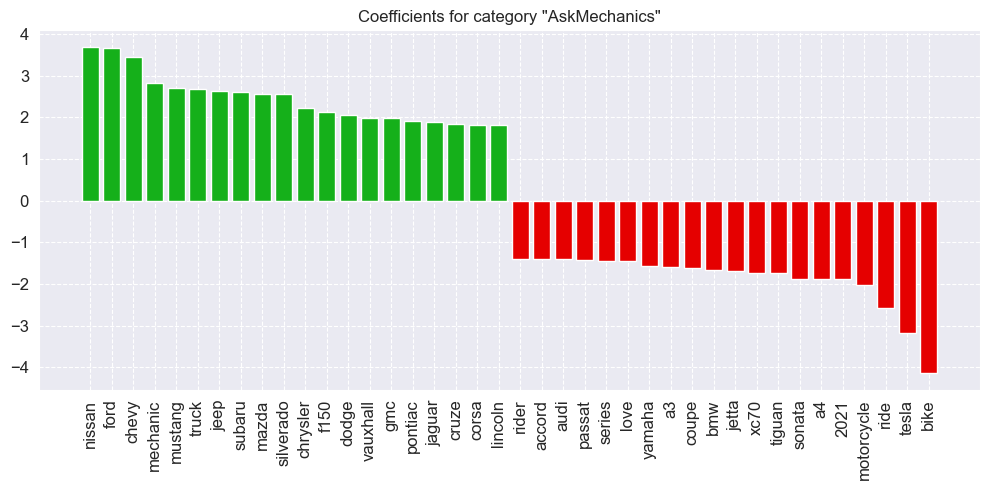

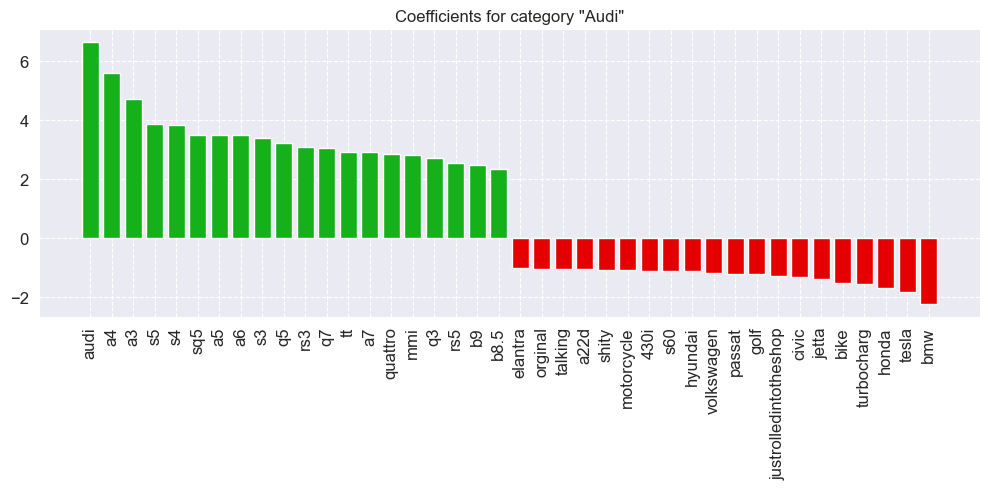

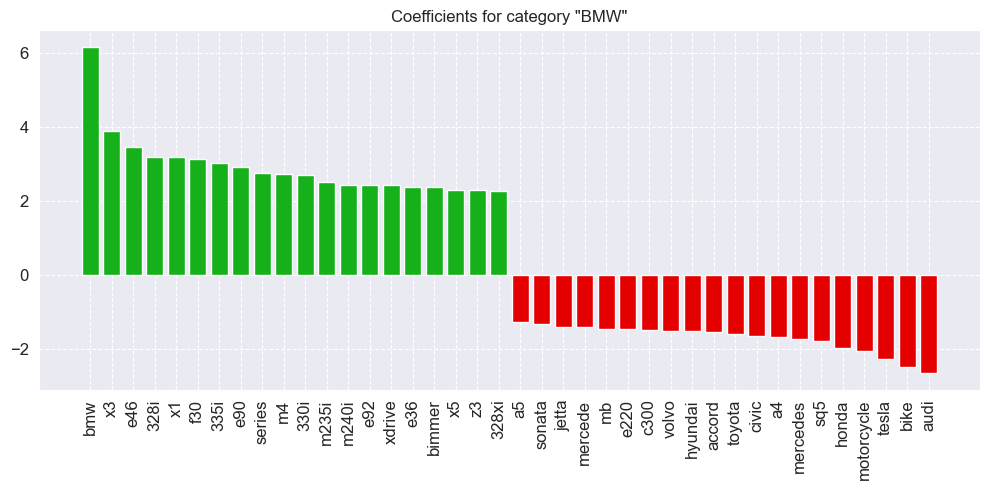

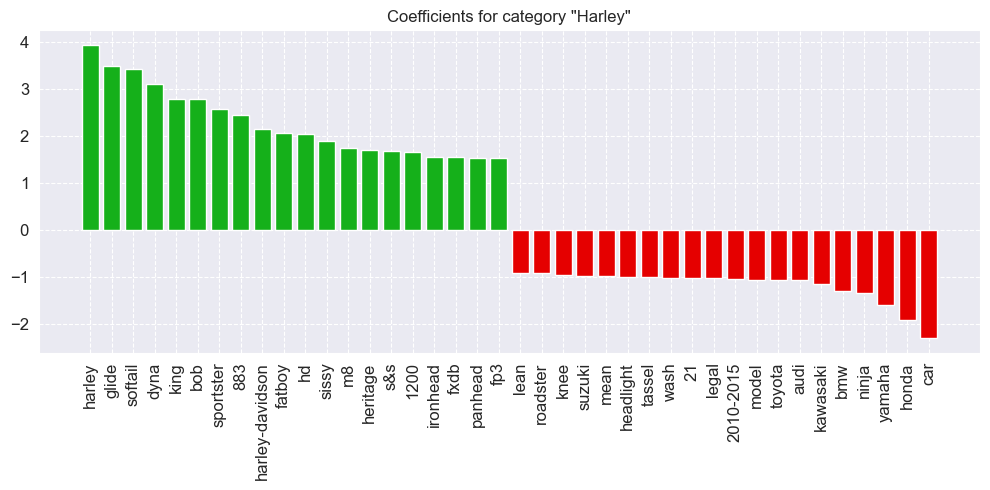

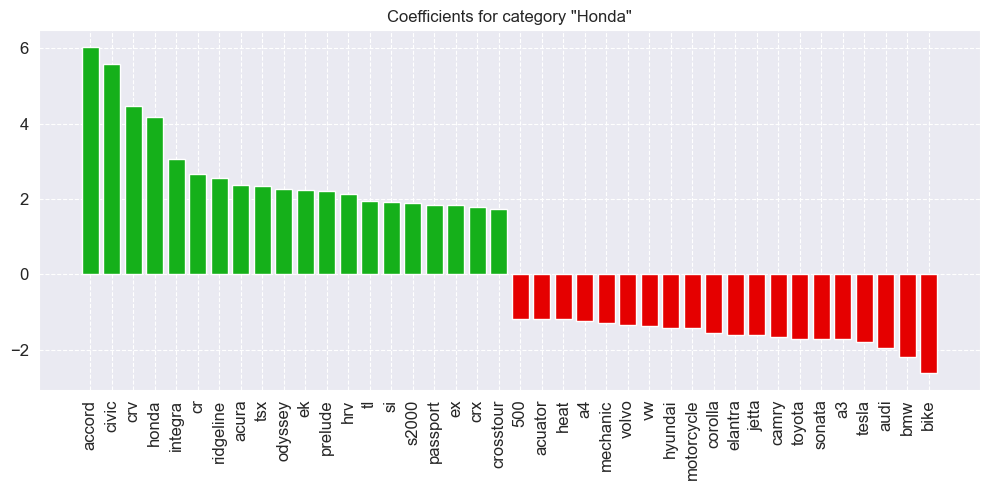

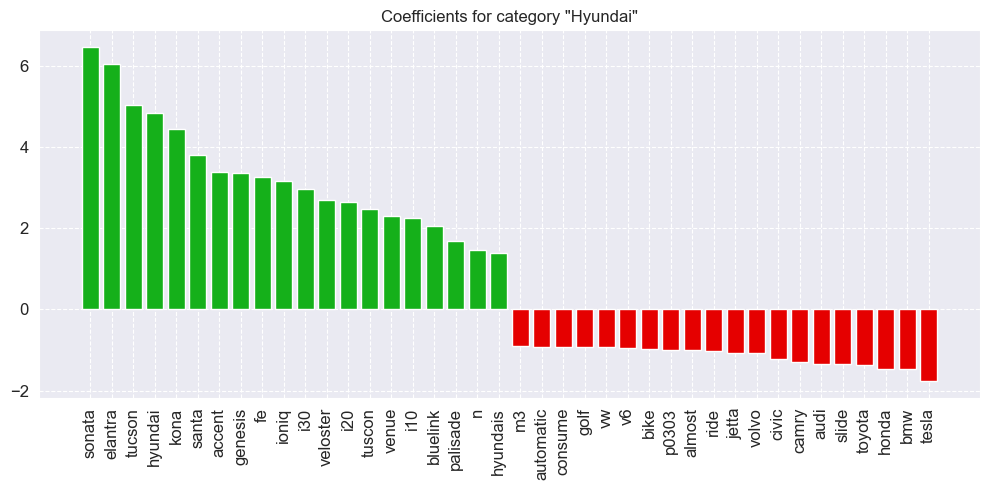

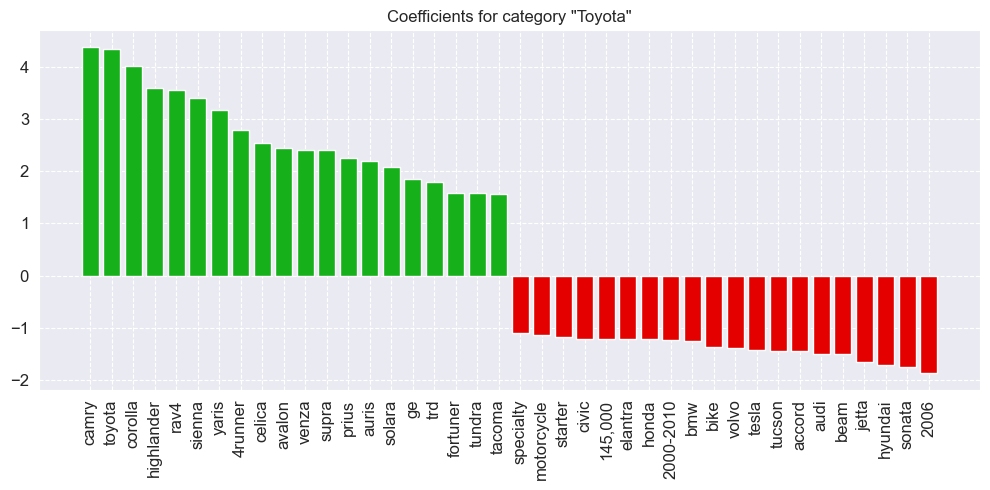

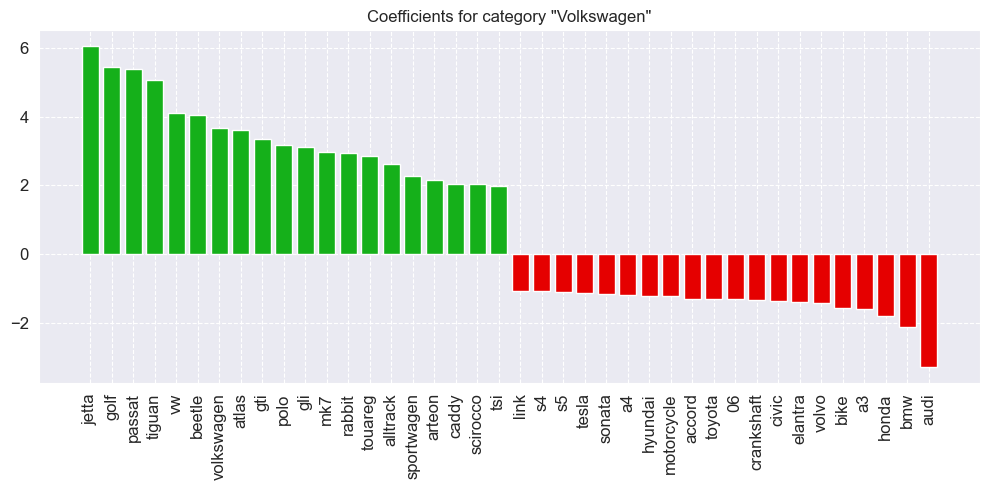

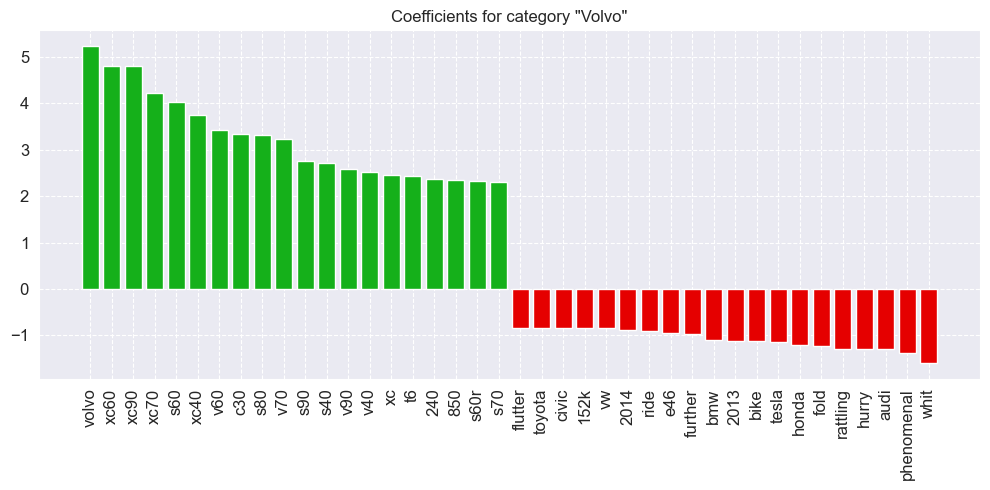

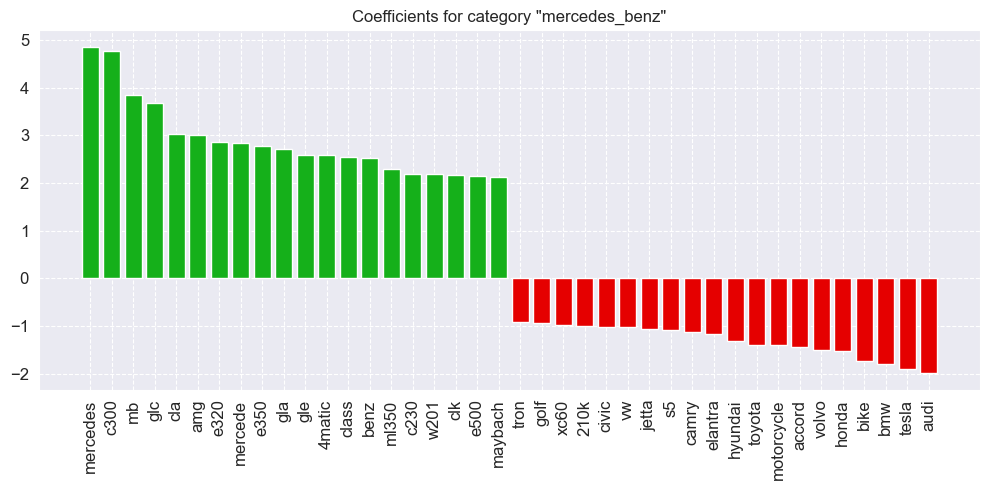

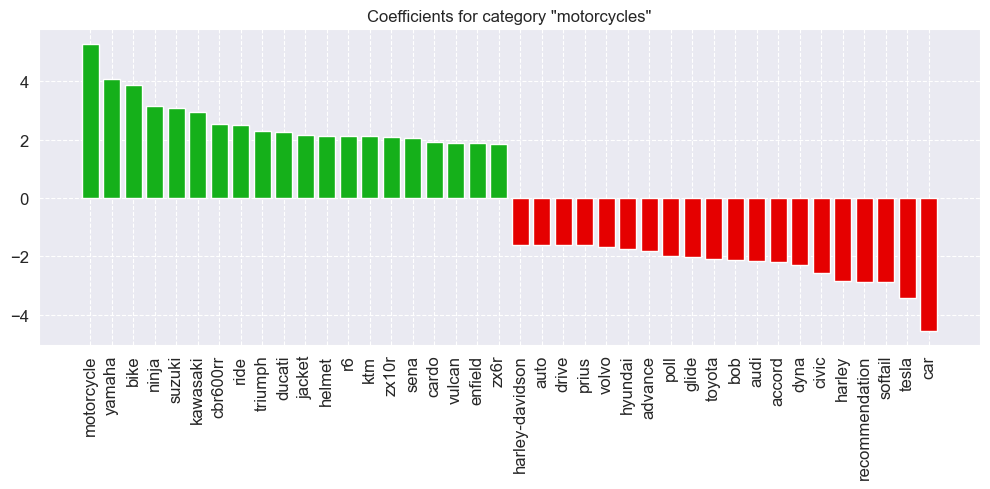

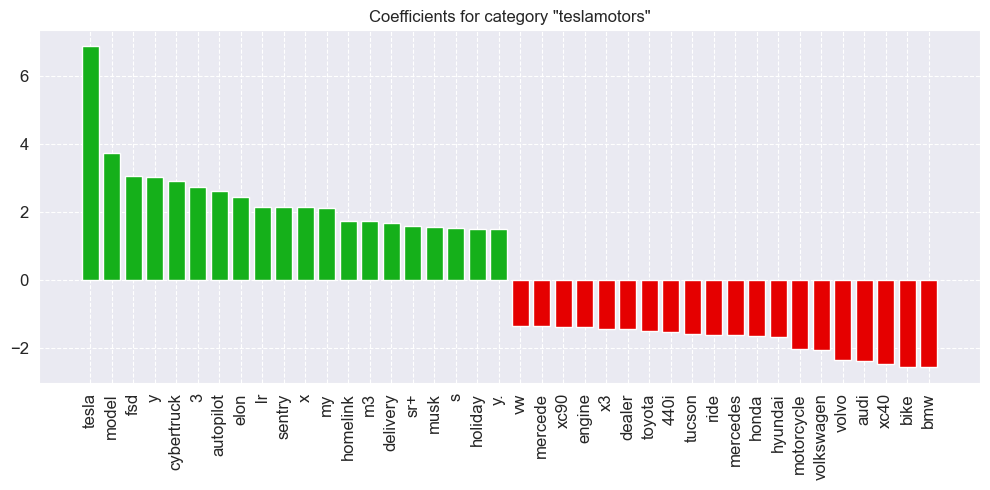

In [27]:
plot_coefficients(clf, count_vect)

### Classifier Explanation with LIME

We need a classifier with prediction probabilities. `LinearSVC` does not yield these. We use Logistic Regression instead.

In [28]:
from sklearn.linear_model import SGDClassifier

print(f'Training on column {label}')

# log loss gives logistic regression
clf = SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=42)

clf.fit(X_train, y_train);

print("Done.")

Training on column subreddit


SGDClassifier(loss='log', random_state=42)

Done.


In [29]:
from sklearn.metrics import accuracy_score

y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

print(f"Classifier: {clf.__class__}\n")

print('Accuracy Summary')
print('================')

print(f'Test:    {accuracy_score(y_test, y_test_pred)*100:6.2f}%')
print(f'Train:   {accuracy_score(y_train, y_train_pred)*100:6.2f}%')

Classifier: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>

Accuracy Summary
Test:     80.32%
Train:    85.19%


In [30]:
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(count_vect, tfidf_vect, clf)

In [31]:
# use lemmas only here, because model is trained on lemmas
samples = [
    "BMW great", 
    "Electric charge take long"
]

pred = pipeline.predict_proba(samples)
pred

array([[0.00614488, 0.01065277, 0.87460269, 0.01138637, 0.00610381,
        0.00828527, 0.01394662, 0.00755892, 0.00904276, 0.00970881,
        0.03519224, 0.00737485],
       [0.04789193, 0.0385718 , 0.03987385, 0.03267383, 0.03202191,
        0.03925107, 0.02788771, 0.02937299, 0.0279932 , 0.04609462,
        0.18890706, 0.44946003]])

In [32]:
pd.options.display.float_format = '{:.4f}'.format

In [33]:
columns = [f"Sample {i+1}" for i in range(pred.shape[0])]

pred_df = pd.DataFrame(pred.T, index=clf.classes_, columns=columns)
pred_df

,Sample 1,Sample 2
AskMechanics,0.0061,0.0479
Audi,0.0107,0.0386
BMW,0.8746,0.0399
Harley,0.0114,0.0327
Honda,0.0061,0.0320
Hyundai,0.0083,0.0393
Toyota,0.0139,0.0279
Volkswagen,0.0076,0.0294
Volvo,0.0090,0.0280
mercedes_benz,0.0097,0.0461


In [34]:
# adjust size of visible columns
pd.set_option('max_colwidth', 3000)

# df.query(f'train_test=="Test" and {label}!=pred')[[label, 'pred', 'text', text_col]].sample(5)

Example: Predicted is "teslamotors", but correct is "Toyota"

In [35]:
df.iloc[7468].to_frame()

,7468
subreddit,Toyota
id,loef7c
created,2021-02-20 20:18:27
title,Rav4: New vs Newer?
text,"Rav4: New vs Newer?: So after looking over things ive decided on getting a Toyota Rav 4 for my new vehicle. New, for once. But im wondering if i should get a 2021 now or wait for the summer(?) and get a 2022 model. TSS/lane centering/etc is a big selling point for me and im given to understand that next years model will have a newer version (2.0 vs 2.5+). So basically im wondering if anyone has driven a vehicle with both versions and if 2.5+ is a noticeable/worth waiting for improvement over 2.0, and what if any other improvements a new year model might have? I'm not up on car stuff, will the 22 model have better mileage/fuel efficiency than the 21?"
num_comments,7
url,https://www.reddit.com/r/Toyota/comments/loef7c/rav4_new_vs_newer/
lemmas,rav4 new newer look thing decide get toyota rav 4 new vehicle new wonder get 2021 wait the summer get 2022 model tss lane center big selling point give understand next year model have new version 2.0 2.5+ wonder drive vehicle version 2.5+ be noticeable worth wait improvement 2.0 other improvement new year model have be car stuff 22 model have well mileage fuel efficiency 21
nouns,rav4 newer thing toyota rav vehicle the summer model tss lane selling point next year model version vehicle version improvement improvement year model car stuff model mileage fuel efficiency
brands,toyota


In [36]:
text = df.iloc[7468]['lemmas']

In [37]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=clf.classes_)

exp = explainer.explain_instance(text, pipeline.predict_proba, num_features=6, top_labels=3)

print([exp.class_names[i] for i in exp.available_labels()])

['teslamotors', 'Toyota', 'Hyundai']


In [38]:
exp.show_in_notebook(text=False)